# Combining all data

In [1]:
!pip install -q easysnowdata

In [53]:
import pandas as pd
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import easysnowdata
import folium
import earthaccess
import numpy as np

from snowexsql.api import LayerMeasurements
import xarray as xr

In [8]:
bbox_gdf = gpd.read_file('../data/grand_mesa.geojson')
sample_area_gdf = gpd.read_file('../data/sample_area.geojson')

start_date = "2019-10-01"
end_date = "2020-09-30"

In [99]:
station_collection = easysnowdata.automatic_weather_stations.StationCollection(sortby_dist_to_geom=bbox_gdf)
station_collection.get_data(['622_CO_SNTL'],variables=['WTEQ','TAVG'])

Sorting by distance to given geometry. See dist_km column.
Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Dataframe has been added to the Station object. Please use the .data attribute to access.


In [163]:
df = pd.read_csv('../contributors/andrea/SP_20.csv',skiprows=32)
df=df[df.Site=='Mesa West Open']
df['SWE'] = df['SWE (mm)'].replace(-9999, np.nan)/1000
df

,Location,Site,PitID,Date/Local Standard Time,UTM Zone,Easting (m),Northing (m),Latitude (deg),Longitude (deg),Density A Mean (kg/m^3),Density B Mean (kg/m^3),Density Mean (kg/m^3),SWE A (mm),SWE B (mm),SWE (mm),HS (cm),Flag,SWE
23,Grand Mesa,Mesa West Open,COGMWO_20200305_0809,2020-03-05T08:09,12N,741079,4324261,39.034176,-108.214801,281,281,281.0,248,247,247.5,88.0,NaN,0.2475
24,Grand Mesa,Mesa West Open,COGMWO_20200316_0841,2020-03-16T08:41,12N,741195,4324281,39.034324,-108.213456,294,295,294.5,330,330,330.0,112.0,NaN,0.3300
25,Grand Mesa,Mesa West Open,COGMWO_20200316_1358,2020-03-16T13:58,12N,741305,4324264,39.034141,-108.212192,282,284,283.0,295,295,295.0,104.0,NaN,0.2950
26,Grand Mesa,Mesa West Open,COGMWO_20200316_1519,2020-03-16T15:19,12N,741085,4324297,39.034498,-108.214719,264,275,269.5,211,220,215.5,80.0,NaN,0.2155
27,Grand Mesa,Mesa West Open,COGMWO_20200331_0934,2020-03-31T09:34,12N,741146,4324202,39.033627,-108.214049,273,272,272.5,378,374,376.0,138.0,NaN,0.3760
28,Grand Mesa,Mesa West Open,COGMWO_20200331_1530,2020-03-31T15:30,12N,741147,4324210,39.033698,-108.214035,300,298,299.0,484,481,482.5,161.0,NaN,0.4825
29,Grand Mesa,Mesa West Open,COGMWO_20200408_1551,2020-04-08T15:51,12N,741161,4324240,39.033964,-108.213863,331,324,327.5,441,430,435.5,133.0,STLay,0.4355
30,Grand Mesa,Mesa West Open,COGMWO_20200409_0550,2020-04-09T05:50,12N,741161,4324223,39.033811,-108.213869,329,337,333.0,455,468,461.5,139.0,STCom,0.4615
31,Grand Mesa,Mesa West Open,COGMWO_20200409_1218,2020-04-09T12:18,12N,741144,4324213,39.033726,-108.214068,354,356,355.0,492,495,493.5,139.0,TDG,0.4935
32,Grand Mesa,Mesa West Open,COGMWO_20200409_1615,2020-04-09T16:15,12N,741158,4324242,39.033983,-108.213896,371,364,367.5,421,412,416.5,113.0,NaN,0.4165


In [19]:
s2 = easysnowdata.remote_sensing.Sentinel2(
    bbox_input=sample_area_gdf,
    start_date=start_date,
    end_date=end_date,
    resolution=10,
    catalog_choice="planetarycomputer",
)

s2.mask_data()
s2.get_rgb()
s2.get_ndsi()

Data searched. Access the returned seach with the .search attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 12N.
Nodata values removed from the data. In doing so, all bands converted to float32. To turn this behavior off, set remove_nodata=False.
Data acquired after January 25th, 2022 harmonized to old baseline. To turn this behavior off, set harmonize_to_old=False.
Data scaled to reflectance. To turn this behavior off, set scale_data=False.
Metadata retrieved. Access with the .metadata attribute.
Removed pixels with the following scene classification values:
No Data (Missing data)
Saturated or defective pixel
Topographic casted shadows
Cloud shadows
Cloud medium probability
Cloud high probability
Thin cirrus
RGB data retrieved. Access with the .rgb attribute, or .rgb_norm for normalized RGB.
NDSI data calculated. Access with the .ndsi attribute.


In [21]:
s2_ndsi_sample_timeseries = s2.ndsi.median(dim=['x','y']).compute()

In [25]:
earthaccess.login()

Enter your Earthdata Login username:  egagli
Enter your Earthdata password:  ········


In [27]:
mod10a1f = easysnowdata.remote_sensing.MODIS_snow(bbox_gdf, start_date=start_date, end_date=end_date, data_product='MOD10A1F')

QUEUEING TASKS | :   0%|          | 0/366 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/366 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/366 [00:00<?, ?it/s]

Data retrieved. Access with the .data attribute.


In [81]:
mod10a1f_ndsi_sample_timeseries = mod10a1f.data.rio.clip(sample_area_gdf.to_crs(mod10a1f.data.rio.crs).geometry).median(dim=['x','y']).compute()
mod10a1f_ndsi_sample_timeseries = mod10a1f_ndsi_sample_timeseries/100

In [39]:
snow_reanalysis_da = easysnowdata.hydroclimatology.get_ucla_snow_reanalysis(
    bbox_gdf,
    start_date=start_date,
    end_date=end_date,
    variable="SWE_Post",
    stats="mean",
)

QUEUEING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/8 [00:00<?, ?it/s]

In [42]:
snow_reanalysis_swe_sample_timeseries = snow_reanalysis_da.rio.clip(sample_area_gdf.geometry).median(dim=['Longitude','Latitude']).compute()

In [ ]:
era5 = easysnowdata.hydroclimatology.get_era5(sample_area_gdf)['2m_temperature'].sel(time=slice(start_date,end_date))
era5_temp_sample_timeseries = era5.resample(time="1D").mean().median(dim=['latitude','longitude']).compute()
era5_temp_sample_timeseries=era5_temp_sample_timeseries-273.15

In [165]:
measurements = LayerMeasurements()
layer_df = LayerMeasurements.from_filter(site_name='Grand Mesa',type='lwc_vol',limit=3000)
gdf = gpd.GeoDataFrame(layer_df, geometry=gpd.points_from_xy(layer_df.longitude,layer_df.latitude),crs=4326)
gdf['date'] = pd.to_datetime(gdf['date'])
gdf = gdf.set_index(['site_id','date','depth'])
gdf = gdf[~gdf.index.duplicated()]
ds = xr.Dataset.from_dataframe(gdf)
ds['site_id']=ds['site_id'].astype(str)
ds['value'] = ds['value'].astype(float)
da = ds['value']#.isel(site_id=slice(0,20))
mesa_west_lwc_da = da.sel(site_id='Mesa West Open',date=slice(start_date,end_date))

In [47]:
s1 = easysnowdata.remote_sensing.Sentinel1(
    bbox_input=sample_area_gdf, start_date=start_date, end_date=end_date, resolution=80, remove_border_noise=False,
)

Data searched. Access the returned seach with the .search attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 12N.
Metadata retrieved. Access with the .metadata attribute.
Added relative orbit number and orbit state as coordinates to the data.
Linear power units converted to dB. Convert back to linear power units using the .db_to_linear() method.


In [50]:
sample_area_proj_gdf = sample_area_gdf.to_crs('EPSG:32612')

In [51]:
s1_rtc_sample_ds = s1.data.rio.clip(sample_area_proj_gdf.geometry)
s1_rtc_sample_median_ds = s1_rtc_sample_ds.median(dim=['x','y']).compute()

(18170.0, 18535.0)

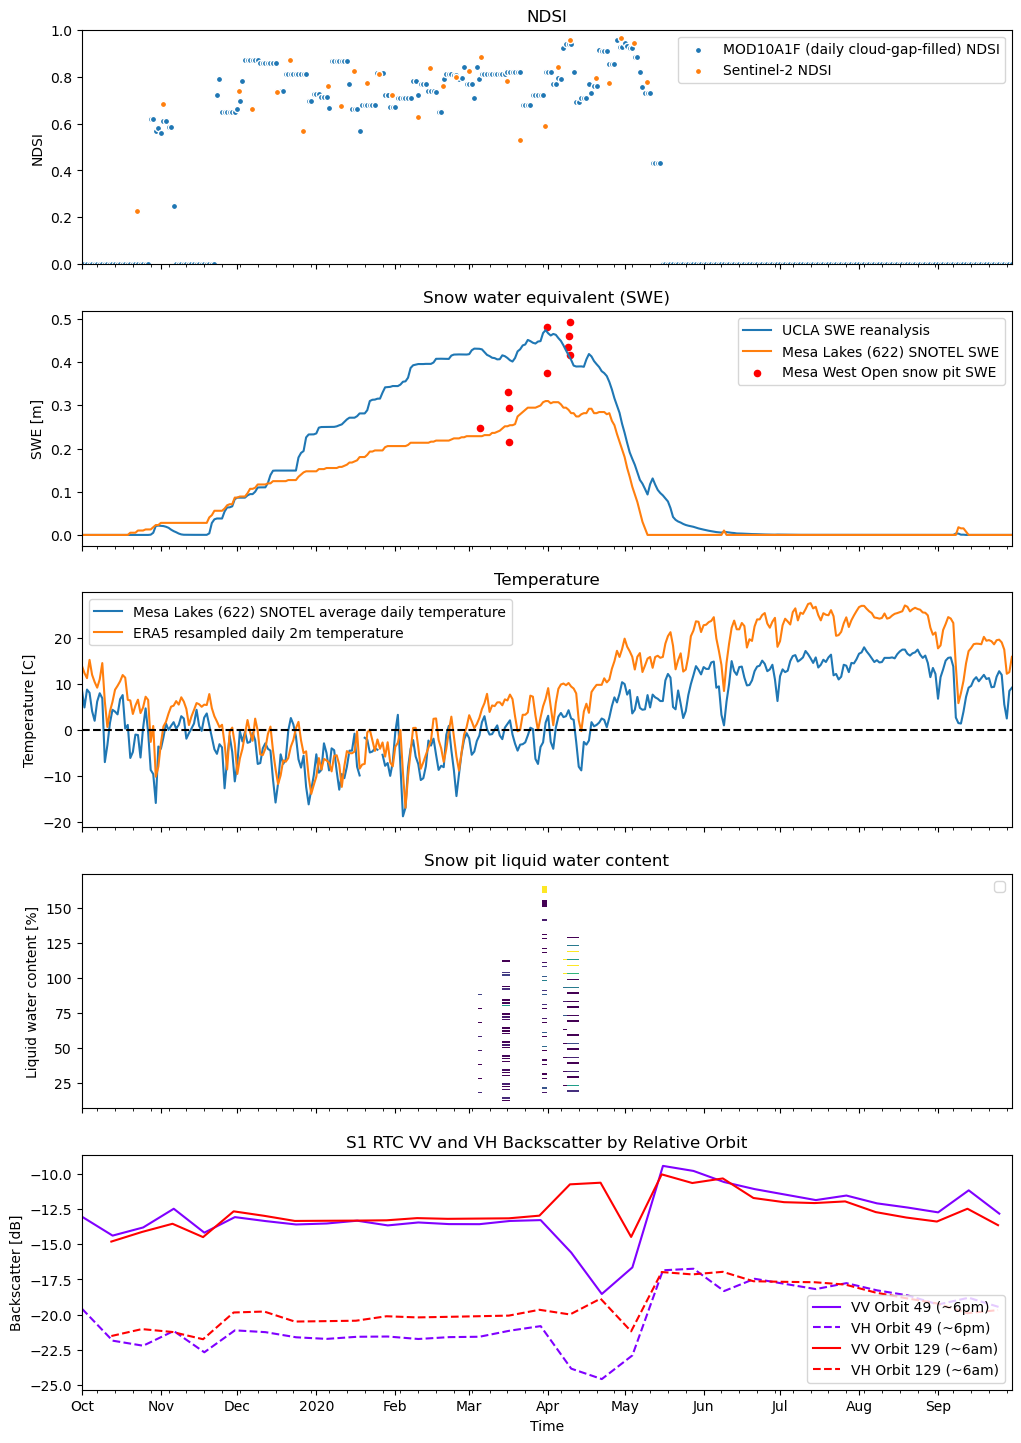

In [181]:
orbits = s1_rtc_sample_median_ds['sat:relative_orbit'].values
unique_orbits = np.unique(orbits)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_orbits)))

f,ax=plt.subplots(figsize=(12,20),nrows=5,sharex=True)

for i, orbit in enumerate(unique_orbits):

    if orbit in [56,151]:
        continue
        
    orbit_data = s1_rtc_sample_median_ds.where(s1_rtc_sample_median_ds['sat:relative_orbit'] == orbit, drop=True)

    time_of_day = "~6pm" if orbit_data['sat:orbit_state'].values[0] == "ascending" else "~6am"
    
    # Plot VV
    ax[4].plot(orbit_data.time, orbit_data.vv, 
             color=colors[i], linestyle='-', label=f'VV Orbit {orbit} ({time_of_day})')
    
    # Plot VH
    ax[4].plot(orbit_data.time, orbit_data.vh, 
             color=colors[i], linestyle='--', label=f'VH Orbit {orbit} ({time_of_day})')

# Customize the plot
ax[4].set_xlabel('Time')
ax[4].set_ylabel('Backscatter [dB]')
ax[4].set_title('S1 RTC VV and VH Backscatter by Relative Orbit')
ax[4].legend()


snow_reanalysis_swe_sample_timeseries.plot(ax=ax[1],label='UCLA SWE reanalysis')
station_collection.data.WTEQ.loc[slice(start_date,end_date)].plot(ax=ax[1],label='Mesa Lakes (622) SNOTEL SWE')

df.plot.scatter(ax=ax[1],x='Date/Local Standard Time',y='SWE',label='Mesa West Open snow pit SWE',color='red')

ax[1].set_ylabel('SWE [m]')
ax[1].set_title('Snow water equivalent (SWE)')
ax[1].set_xlabel('')
ax[1].legend()

mod10a1f_ndsi_sample_timeseries.plot.scatter(x='time',ax=ax[0],label='MOD10A1F (daily cloud-gap-filled) NDSI',s=20)
s2_ndsi_sample_timeseries.plot.scatter(x='time',ax=ax[0],label='Sentinel-2 NDSI',s=20)

ax[0].set_ylabel('NDSI')
#ax[0].set_title('Snow water equivalent (SWE)')
ax[0].set_title('NDSI')
ax[0].set_xlabel('')
ax[0].legend()
ax[0].set_ylim([0,1])


station_collection.data.TAVG.loc[slice(start_date,end_date)].plot(ax=ax[2],label='Mesa Lakes (622) SNOTEL average daily temperature')
era5_temp_sample_timeseries.plot(ax=ax[2],label='ERA5 resampled daily 2m temperature')
ax[2].set_ylabel('Temperature [C]')
ax[2].axhline(y=0, linestyle='--',color='black')
ax[2].set_title('Temperature')
ax[2].set_xlabel('')
ax[2].legend()



mesa_west_lwc_da.plot.pcolormesh(
    ax=ax[3],
    x='date',
    y='depth',
    cmap='viridis',  # You can change this to any colormap you prefer
    #cbar_kwargs={'label': 'Liquid Water Content [%]'},
    vmax=2,
    label='Mesa West Open snow pit LWC',
    add_colorbar=False
)
ax[3].set_ylabel('Liquid water content [%]')
ax[3].set_title('Snow pit liquid water content')
ax[3].set_xlabel('')
ax[3].legend()


ax[0].set_xlim([pd.to_datetime(start_date),pd.to_datetime(end_date)])